<a href="https://colab.research.google.com/github/srishtimotwani3/ML_Lab/blob/main/Robotics__Tutorial_CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard libraries & common image-processing packages
import numpy as np
import cv2               # pip install opencv-python
from matplotlib import pyplot as plt
from skimage import exposure, restoration, util
from scipy import fftpack, ndimage, signal
from scipy.signal import convolve2d
from skimage.filters import median, sobel
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray
from skimage import io
import math

# File paths
SOLO_IMG_PATH  = "/content/sole_object_image.jpg"   # photo in which you are the sole subject
SCENE_IMG_PATH = "/content/image_with_bg_elements.jpg"  # photo featuring yourself along with background elements

# Helper: show image inline
def show(img, title="", cmap=None, figsize=(6,6)):
    plt.figure(figsize=figsize)
    if img.ndim==2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        # convert BGR (cv2) to RGB for display
        if img.shape[2]==3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# read images using OpenCV (BGR)
solo_bgr  = cv2.imread(SOLO_IMG_PATH)
scene_bgr = cv2.imread(SCENE_IMG_PATH)

if solo_bgr is None:
    raise FileNotFoundError(f"Could not find or open {SOLO_IMG_PATH}")
if scene_bgr is None:
    raise FileNotFoundError(f"Could not find or open {SCENE_IMG_PATH}")

# Convert to grayscale 8-bit images for tasks that need grayscale
solo_gray  = cv2.cvtColor(solo_bgr, cv2.COLOR_BGR2GRAY)
scene_gray = cv2.cvtColor(scene_bgr, cv2.COLOR_BGR2GRAY)

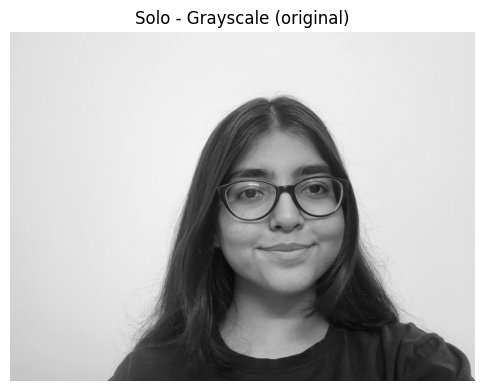

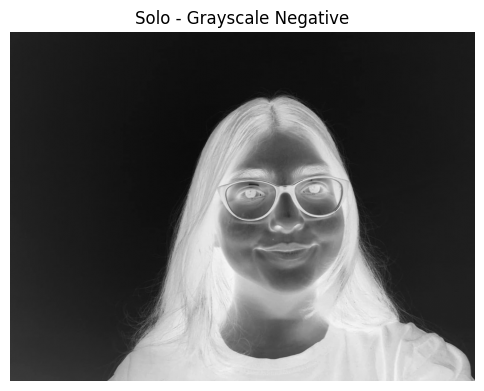

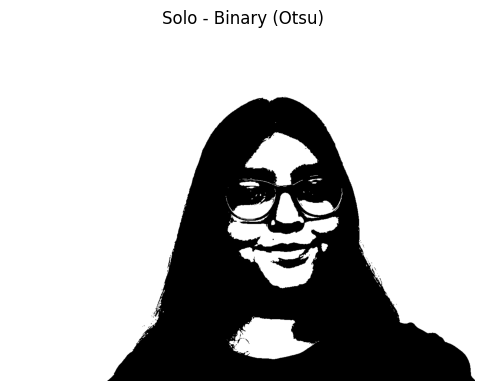

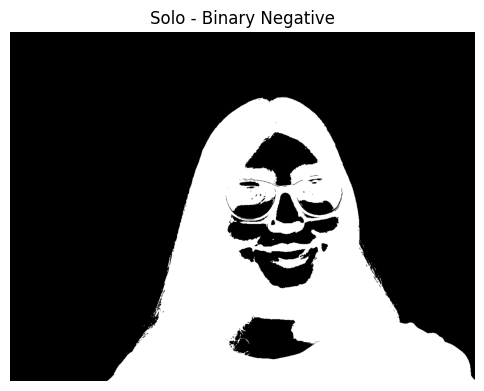

In [2]:
# Take a photo in which you are the sole subject and perform the following:
# 1. Simulation and Display of an Image, Negative of an Image (Binary & Gray Scale)

# GRAYSCALE NEGATIVE
solo_gray_neg = 255 - solo_gray
show(solo_gray, "Solo - Grayscale (original)")
show(solo_gray_neg, "Solo - Grayscale Negative")

# BINARY (thresholding) and its negative
# Otsu's threshold - automatic
_, solo_bin = cv2.threshold(solo_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
solo_bin_neg = 255 - solo_bin

show(solo_bin, "Solo - Binary (Otsu)")
show(solo_bin_neg, "Solo - Binary Negative")

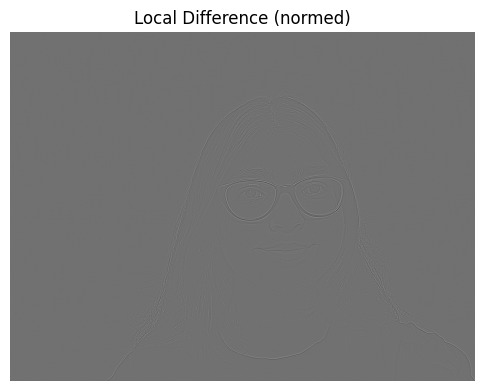

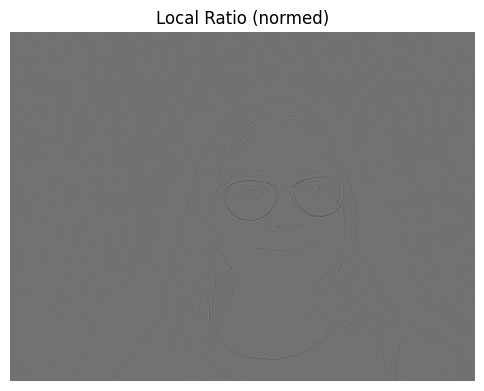

In [3]:
# 2. Implementation of Relationships between Pixels

# We'll compute several pixel relationships:
# - Local difference (center pixel minus mean of 8-neighbors)
# - Local ratio
# - Structural similarity-like local correlation (simplified)

# Pad image for neighbor access
pad = np.pad(solo_gray.astype(np.int16), 1, mode='reflect')
h, w = solo_gray.shape

# compute neighbor mean and difference
neighbor_mean = np.zeros_like(solo_gray, dtype=np.float32)
neighbor_var  = np.zeros_like(solo_gray, dtype=np.float32)
for i in range(h):
    for j in range(w):
        patch = pad[i:i+3, j:j+3]
        center = patch[1,1]
        neighbors = np.delete(patch.flatten(), 4)  # remove center
        neighbor_mean[i,j] = neighbors.mean()
        neighbor_var[i,j]  = neighbors.var()

local_diff = (solo_gray.astype(np.float32) - neighbor_mean)
local_ratio = solo_gray.astype(np.float32) / (neighbor_mean + 1e-6)  # avoid div0

# Normalize for visualization
ld_vis = cv2.normalize(local_diff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
lr_vis = cv2.normalize(local_ratio, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show(ld_vis, "Local Difference (normed)")
show(lr_vis, "Local Ratio (normed)")

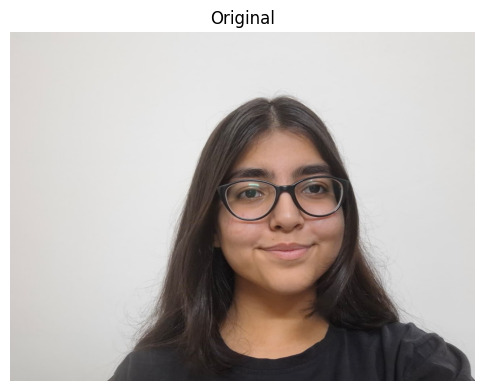

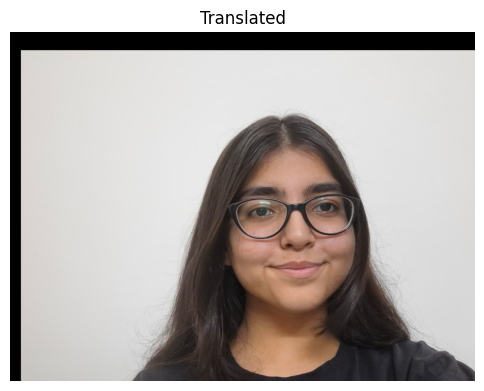

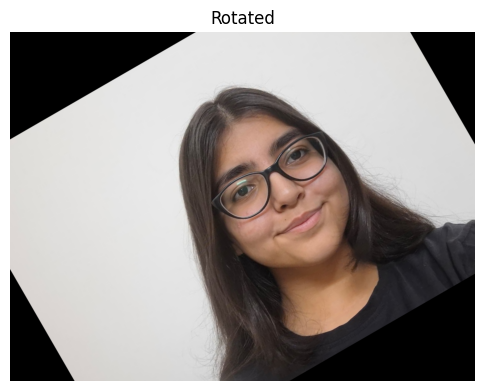

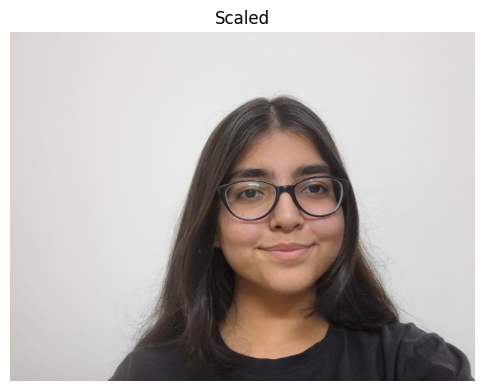

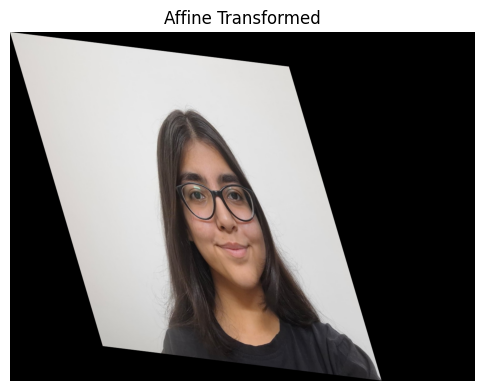

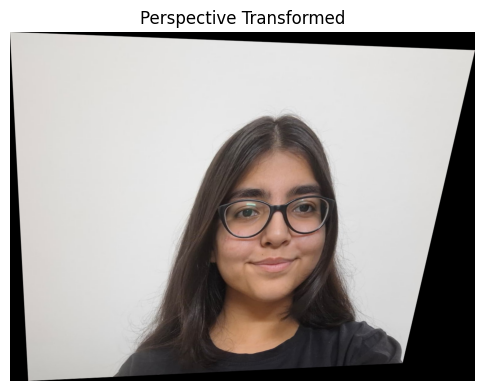

In [4]:
# 3. Implementation of Transformations of an Image

# Helper transform display
def transform_and_show(img_bgr):
    h, w = img_bgr.shape[:2]

    # Translation
    M_trans = np.float32([[1,0,30],[0,1,50]])
    trans = cv2.warpAffine(img_bgr, M_trans, (w, h))

    # Rotation about center
    M_rot = cv2.getRotationMatrix2D((w//2,h//2), angle=30, scale=1.0)
    rot = cv2.warpAffine(img_bgr, M_rot, (w, h))

    # Scaling (resize)
    scaled = cv2.resize(img_bgr, None, fx=0.6, fy=0.6, interpolation=cv2.INTER_LINEAR)

    # Affine (shear + rotate)
    src_tri = np.float32([[0,0],[w-1,0],[0,h-1]])
    dst_tri = np.float32([[0,0],[int(0.6*(w-1)), int(0.1*(h-1))],[int(0.2*(w-1)), int(0.9*(h-1))]])
    M_aff = cv2.getAffineTransform(src_tri, dst_tri)
    aff = cv2.warpAffine(img_bgr, M_aff, (w, h))

    # Perspective transform (simple)
    src_pts = np.float32([[0,0],[w-1,0],[w-1,h-1],[0,h-1]])
    dst_pts = np.float32([[0,0],[w-1,50],[w-200,h-50],[50,h-1]])
    M_pers = cv2.getPerspectiveTransform(src_pts, dst_pts)
    pers = cv2.warpPerspective(img_bgr, M_pers, (w, h))

    show(img_bgr, "Original")
    show(trans, "Translated")
    show(rot, "Rotated")
    show(scaled, "Scaled")
    show(aff, "Affine Transformed")
    show(pers, "Perspective Transformed")

# Apply to solo image
transform_and_show(solo_bgr)

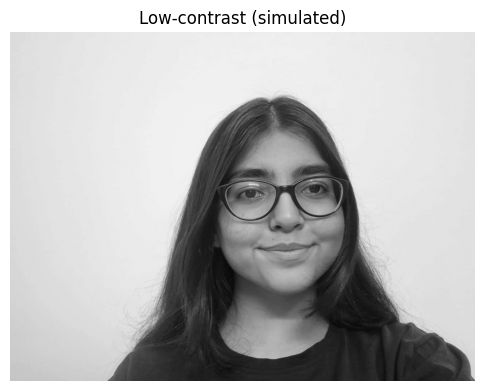

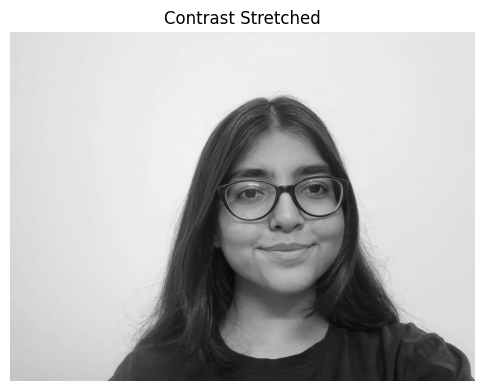

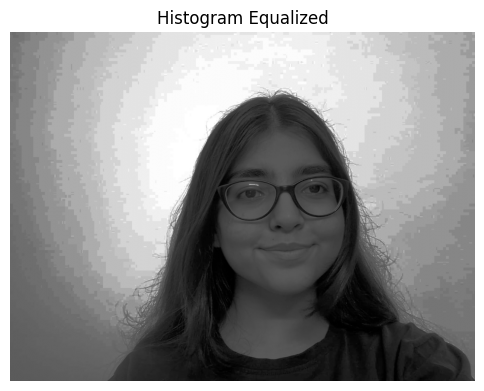

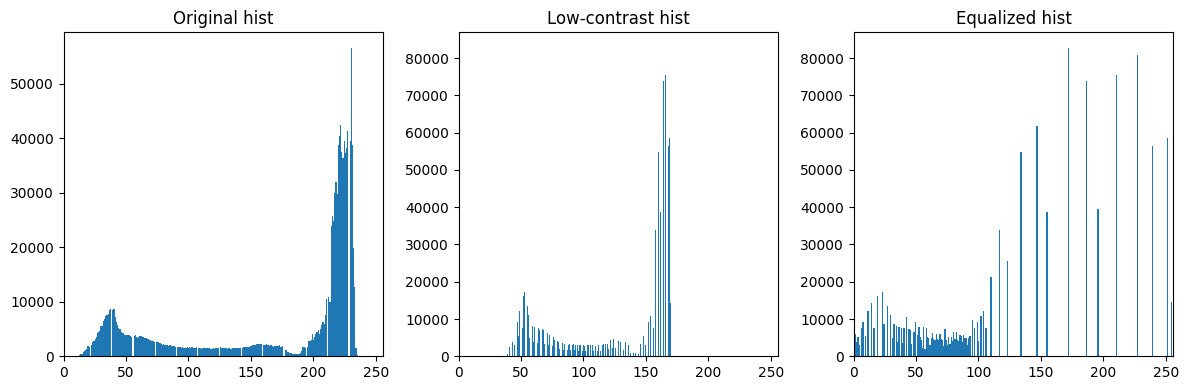

In [5]:
# 4. Contrast stretching of a low contrast image, Histogram, and Histogram Equalization

# Contrast stretching (simple linear stretch to full 0..255)
def contrast_stretch(img_gray):
    a = img_gray.min()
    b = img_gray.max()
    stretched = ((img_gray - a) * (255.0 / (b - a))).astype(np.uint8)
    return stretched

# create a deliberately low-contrast version for demo (alpha-beta)
low_contrast = cv2.convertScaleAbs(solo_gray, alpha=0.6, beta=30)  # reduced contrast + offset
stretched = contrast_stretch(low_contrast)

# Histogram and equalization
hist_orig, bins = np.histogram(low_contrast.flatten(), 256, [0,256])
hist_eq_img = cv2.equalizeHist(low_contrast)

show(low_contrast, "Low-contrast (simulated)")
show(stretched, "Contrast Stretched")
show(hist_eq_img, "Histogram Equalized")

# Plot histograms
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original hist"); plt.hist(solo_gray.flatten(), bins=256); plt.xlim([0,256])
plt.subplot(1,3,2); plt.title("Low-contrast hist"); plt.hist(low_contrast.flatten(), bins=256); plt.xlim([0,256])
plt.subplot(1,3,3); plt.title("Equalized hist"); plt.hist(hist_eq_img.flatten(), bins=256); plt.xlim([0,256])
plt.tight_layout()

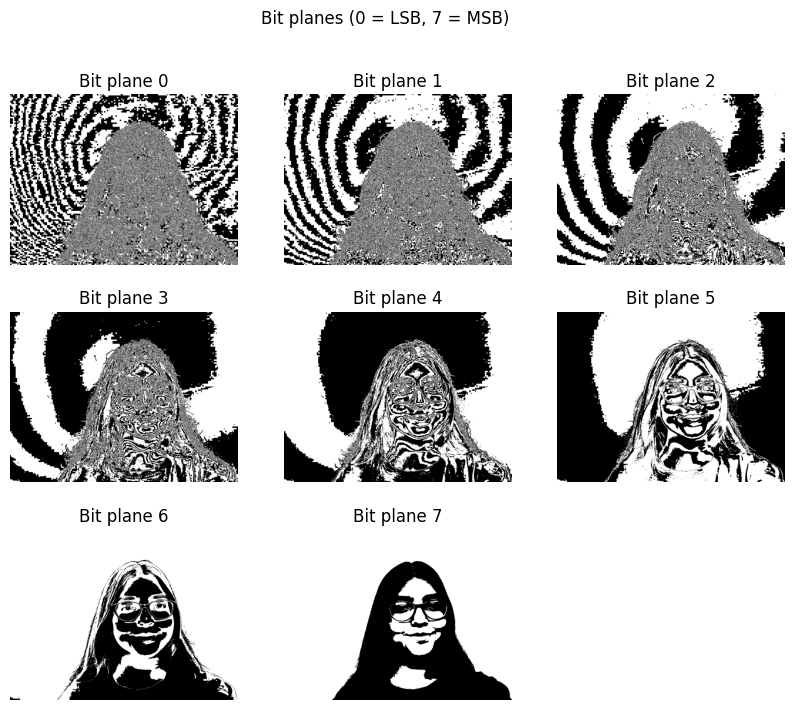

In [6]:
# 5. Display of bit planes of an Image

# Extract 8 bit planes of grayscale solo image
bit_planes = []
for b in range(8):
    plane = ((solo_gray >> b) & 1) * 255
    bit_planes.append(plane.astype(np.uint8))

# Display a 3x3 grid (last will be empty)
plt.figure(figsize=(10,8))
for i, bp in enumerate(bit_planes):
    plt.subplot(3,3,i+1)
    plt.imshow(bp, cmap='gray')
    plt.title(f'Bit plane {i}')
    plt.axis('off')
plt.subplot(3,3,9); plt.axis('off')  # filler
plt.suptitle("Bit planes (0 = LSB, 7 = MSB)")
plt.show()

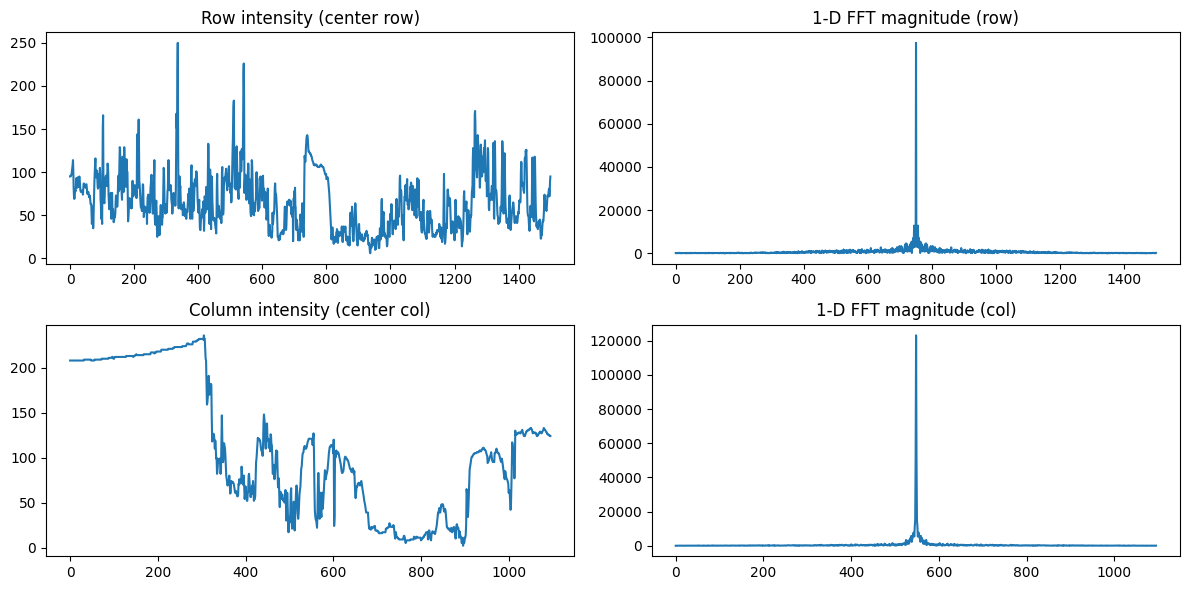

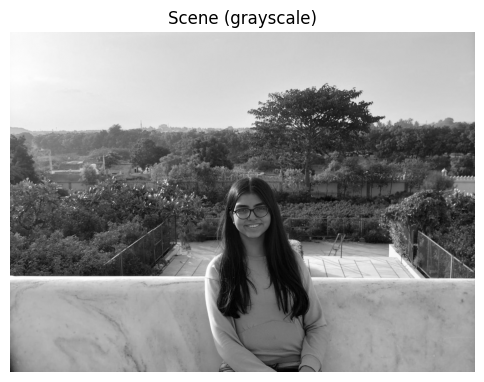

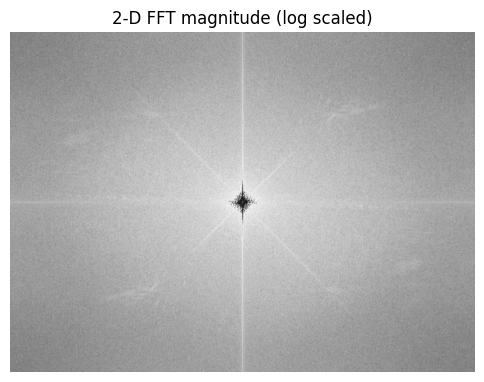

In [7]:
# Take a photo featuring yourself along with background elements and perform the following:

# 6. Display of FFT(1-D & 2-D) of an image

# 1-D FFT: compute row-wise and column-wise examples
row = scene_gray[scene_gray.shape[0]//2, :].astype(np.float32)
col = scene_gray[:, scene_gray.shape[1]//2].astype(np.float32)

# 1D FFT
row_fft = np.fft.fftshift(np.fft.fft(row))
col_fft = np.fft.fftshift(np.fft.fft(col))

plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plt.plot(row); plt.title("Row intensity (center row)")
plt.subplot(2,2,2); plt.plot(np.abs(row_fft)); plt.title("1-D FFT magnitude (row)")
plt.subplot(2,2,3); plt.plot(col); plt.title("Column intensity (center col)")
plt.subplot(2,2,4); plt.plot(np.abs(col_fft)); plt.title("1-D FFT magnitude (col)")
plt.tight_layout()

# 2-D FFT
f = np.fft.fft2(scene_gray.astype(np.float32))
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift) + 1e-8)

show(scene_gray, "Scene (grayscale)")
show(magnitude_spectrum.astype(np.uint8), "2-D FFT magnitude (log scaled)")

In [8]:
# 7. Computation of Mean, Standard Deviation, Correlation coefficient of the given Image

# Use scene_gray (grayscale) for statistics
mean_val = scene_gray.mean()
std_val  = scene_gray.std()

# Correlation coefficient between R and G channels (for color image)
scene_rgb = cv2.cvtColor(scene_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
R = scene_rgb[:,:,0].flatten()
G = scene_rgb[:,:,1].flatten()
B = scene_rgb[:,:,2].flatten()

corr_RG = np.corrcoef(R, G)[0,1]
corr_RB = np.corrcoef(R, B)[0,1]
corr_GB = np.corrcoef(G, B)[0,1]

print(f"Scene mean (grayscale): {mean_val:.3f}")
print(f"Scene std  (grayscale): {std_val:.3f}")
print(f"Correlation R-G: {corr_RG:.4f}, R-B: {corr_RB:.4f}, G-B: {corr_GB:.4f}")

Scene mean (grayscale): 135.757
Scene std  (grayscale): 69.477
Correlation R-G: 0.9831, R-B: 0.9432, G-B: 0.9713


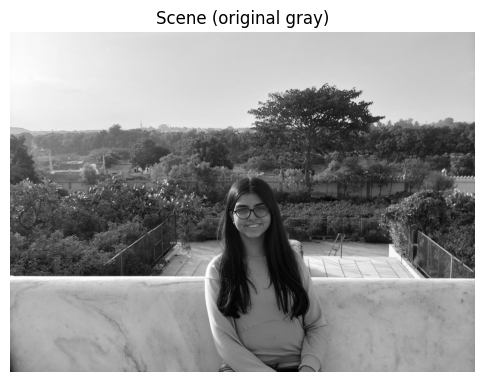

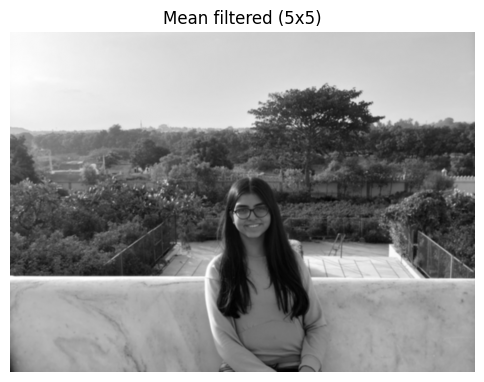

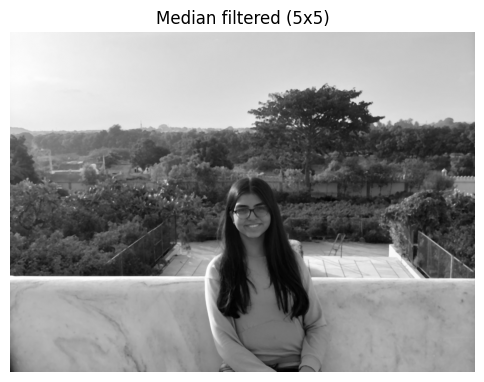

In [9]:
# 8. Implementation of Image Smoothening Filters (Mean and Median filtering of an Image)

# Mean filter (via cv2.blur) and Median filter
mean_filtered = cv2.blur(scene_gray, (5,5))
median_filtered = cv2.medianBlur(scene_gray, ksize=5)

show(scene_gray, "Scene (original gray)")
show(mean_filtered, "Mean filtered (5x5)")
show(median_filtered, "Median filtered (5x5)")

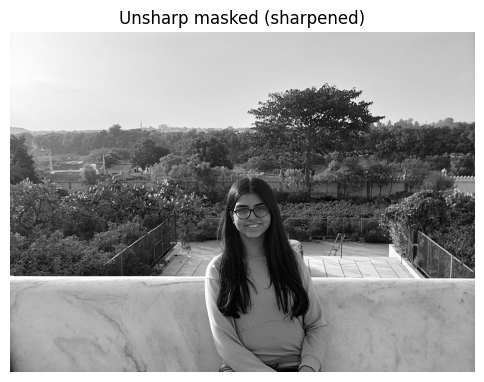

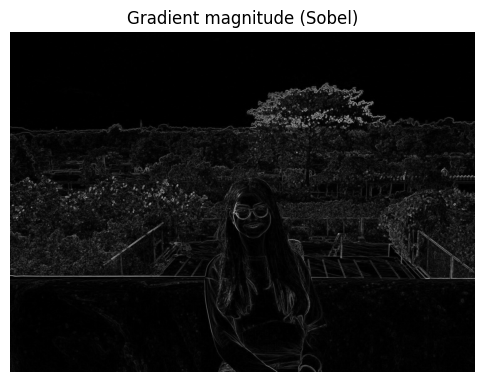

In [10]:
# 9. Implementation of image sharpening filters and Edge Detection using Gradient Filters

# Sharpening via unsharp mask
gauss = cv2.GaussianBlur(scene_gray, (9,9), 10.0)
unsharp = cv2.addWeighted(scene_gray, 1.5, gauss, -0.5, 0)

# Gradient edge detection: Sobel (x,y), magnitude, and canny (later)
sobelx = cv2.Sobel(scene_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(scene_gray, cv2.CV_64F, 0, 1, ksize=3)
grad_mag = np.sqrt(sobelx**2 + sobely**2)
grad_mag_u8 = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

show(unsharp, "Unsharp masked (sharpened)")
show(grad_mag_u8, "Gradient magnitude (Sobel)")

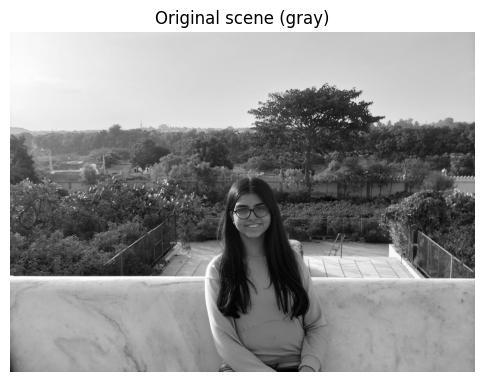

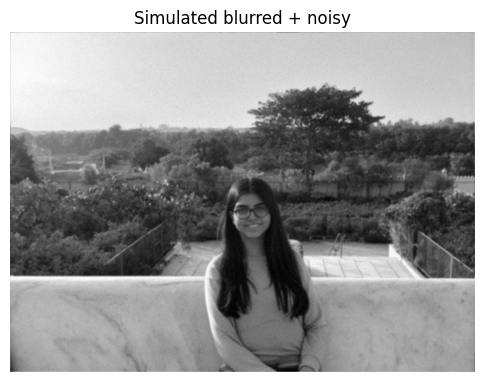

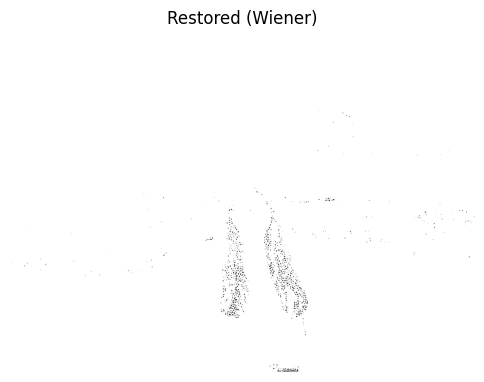

In [11]:
# 10. Implementation of image restoring techniques

# Simulate blurring and additive noise, then restore using Wiener
from scipy.signal import convolve2d
def gaussian_kernel(kernlen=21, sigma=3):
    ax = np.linspace(-(kernlen-1)/2., (kernlen-1)/2., kernlen)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5*(np.square(xx)+np.square(yy))/np.square(sigma))
    return kernel / np.sum(kernel)

# Create blurred + noisy image
kernel = gaussian_kernel(9, 2)
blurred = convolve2d(scene_gray.astype(np.float32), kernel, mode='same', boundary='wrap')
noise = np.random.normal(0, 8, scene_gray.shape)
blur_noisy = np.clip(blurred + noise, 0, 255).astype(np.uint8)

# Wiener deconvolution (Wiener filter using skimage.restoration)
psf = kernel
restored = restoration.wiener(blur_noisy, psf, balance=0.01, clip=True)
restored_u8 = img_as_ubyte(restored)

show(scene_gray, "Original scene (gray)")
show(blur_noisy.astype(np.uint8), "Simulated blurred + noisy")
show(restored_u8, "Restored (Wiener)")

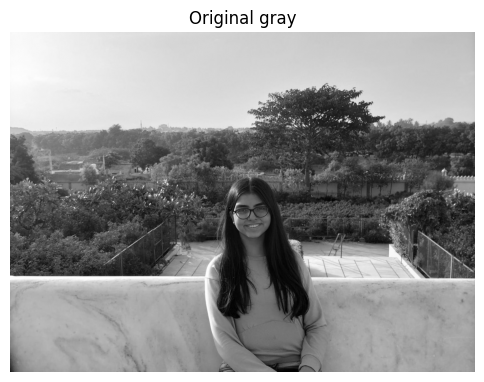

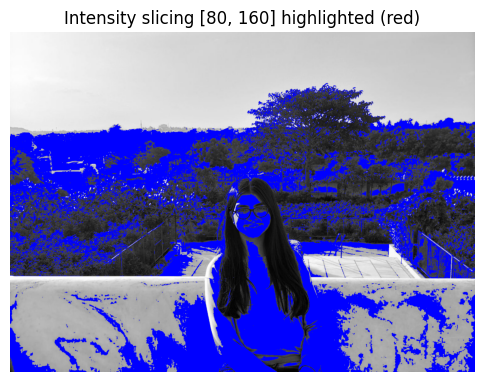

In [12]:
# 11. Implementation of Image Intensity slicing technique for image enhancement

# Intensity slicing: highlight a range of intensities; convert others to background
# Example: highlight mid-bright region
img = scene_gray.copy().astype(np.uint8)
low, high = 80, 160  # change these bounds to target intensity ranges
slice_mask = np.logical_and(img >= low, img <= high)

# Create an RGB overlay showing slice in red
overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
overlay[slice_mask] = [255, 0, 0]  # red highlight for sliced intensities

show(img, "Original gray")
show(overlay, f"Intensity slicing [{low}, {high}] highlighted (red)")

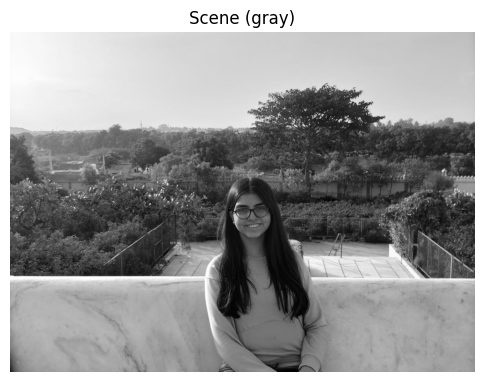

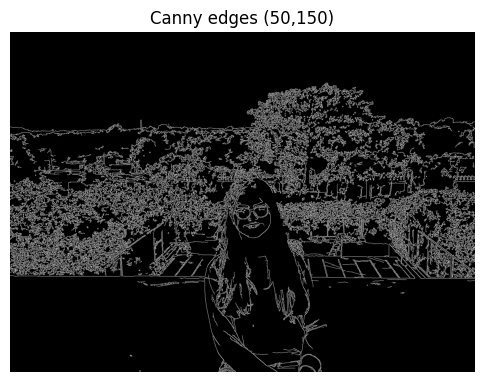

In [13]:
# 12. Canny edge detection Algorithm

# Canny edge detection (use scene_gray)
edges = cv2.Canny(scene_gray, threshold1=50, threshold2=150, apertureSize=3, L2gradient=True)
show(scene_gray, "Scene (gray)")
show(edges, "Canny edges (50,150)")